# Resolución del Desafío Telecom X
Este notebook documenta paso a paso el análisis exploratorio y modelado simple para el churn de clientes de Telecom X.

**Índice:**
1. Introducción
2. Carga y exploración de datos
3. Normalización de columnas anidadas
4. Revisión y limpieza de datos
5. Análisis exploratorio y visualizaciones
6. Modelado simple de churn
7. Conclusiones

## 1️⃣ Introducción
El objetivo es identificar patrones de evasión de clientes (churn) y preparar los datos para modelos predictivos.

In [2]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

## 2️⃣ Carga y exploración de datos
Se carga el archivo JSON y se visualizan las primeras filas y la estructura.

In [3]:
# Cargar los datos
df = pd.read_json('TelecomX_Data.json')
df.head()

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


In [4]:
# Información general
print(df.shape)
df.info()
print(df.isnull().sum())
print(df.isna().sum())

(7267, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerID  7267 non-null   object
 1   Churn       7267 non-null   object
 2   customer    7267 non-null   object
 3   phone       7267 non-null   object
 4   internet    7267 non-null   object
 5   account     7267 non-null   object
dtypes: object(6)
memory usage: 340.8+ KB
customerID    0
Churn         0
customer      0
phone         0
internet      0
account       0
dtype: int64
customerID    0
Churn         0
customer      0
phone         0
internet      0
account       0
dtype: int64


## 3️⃣ Normalización de columnas anidadas
Las columnas `customer`, `phone`, `internet` y `account` contienen diccionarios. Se expanden para obtener un DataFrame plano.

In [14]:
# Expandir columnas anidadas
customer_df = pd.json_normalize(df['customer'])
phone_df = pd.json_normalize(df['phone'])
internet_df = pd.json_normalize(df['internet'])
account_df = pd.json_normalize(df['account'])
df_flat = pd.concat([
    df[['customerID', 'Churn']],
    customer_df,
    phone_df,
    internet_df,
    account_df
], axis=1)
df_flat.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


In [15]:
# Filtrar filas con valores válidos en 'Churn'
df_flat = df_flat[df_flat['Churn'] != ""]

## 4️⃣ Revisión y limpieza de datos
Conversión de tipos, tratamiento de nulos y revisión de la estructura final.

In [16]:
# Convertir columnas numéricas y tratar nulos
if 'SeniorCitizen' in df_flat.columns:
    df_flat['SeniorCitizen'] = df_flat['SeniorCitizen'].astype(int)
for col in ['tenure', 'Charges.Monthly', 'Charges.Total']:
    if col in df_flat.columns:
        df_flat[col] = pd.to_numeric(df_flat[col], errors='coerce')
df_flat.info()
df_flat.isnull().sum()
df_flat.isna().sum()
df_flat.fillna(0, inplace=True)  # Imputar nulos con la media

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Churn             7043 non-null   object 
 2   gender            7043 non-null   object 
 3   SeniorCitizen     7043 non-null   int64  
 4   Partner           7043 non-null   object 
 5   Dependents        7043 non-null   object 
 6   tenure            7043 non-null   int64  
 7   PhoneService      7043 non-null   object 
 8   MultipleLines     7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  Contract          7043 non-null   object 
 17  

## 5️⃣ Análisis exploratorio y visualizaciones
Exploración de variables clave y visualización de patrones de churn.

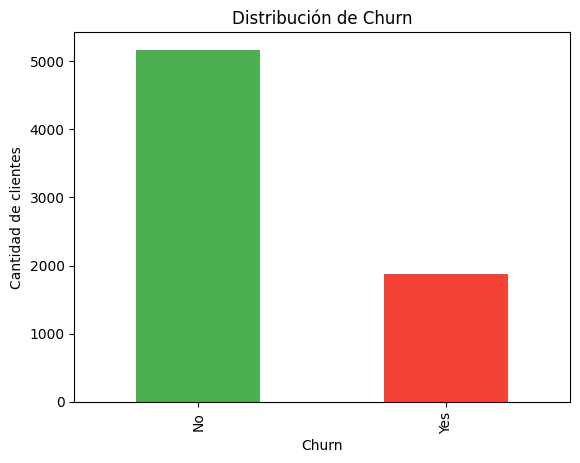

In [17]:
# Distribución de churn
df_flat['Churn'].value_counts().plot(kind='bar', color=['#4CAF50', '#F44336'])
plt.title('Distribución de Churn')
plt.xlabel('Churn')
plt.ylabel('Cantidad de clientes')
plt.show()

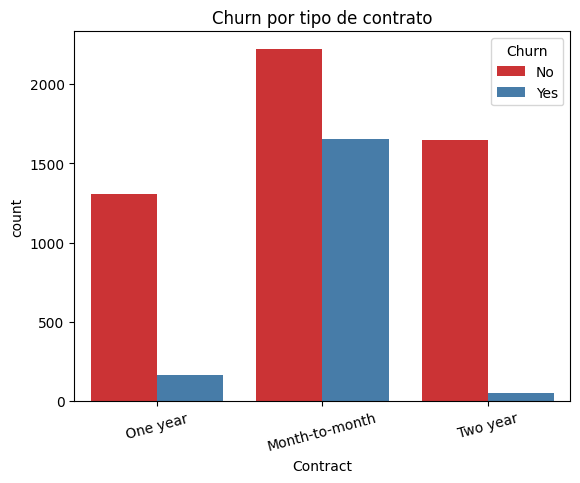

In [18]:
# Churn por tipo de contrato
if 'Contract' in df_flat.columns:
    sns.countplot(data=df_flat, x='Contract', hue='Churn', palette='Set1')
    plt.title('Churn por tipo de contrato')
    plt.xticks(rotation=15)
    plt.show()

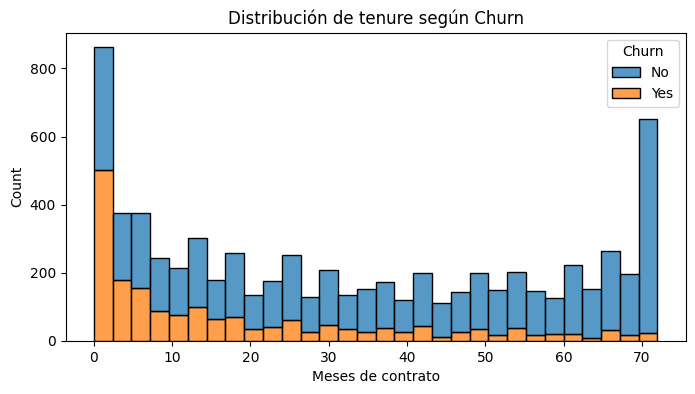

In [19]:
# Distribución de tenure según Churn
if 'tenure' in df_flat.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(data=df_flat, x='tenure', hue='Churn', multiple='stack', bins=30)
    plt.title('Distribución de tenure según Churn')
    plt.xlabel('Meses de contrato')
    plt.show()

## 6️⃣ Modelado simple de churn
Se entrena un modelo de regresión logística con las variables más relevantes y se evalúa su desempeño.

In [20]:
# Selección de variables independientes
features = []
if 'tenure' in df_flat.columns:
    features.append('tenure')
if 'SeniorCitizen' in df_flat.columns:
    features.append('SeniorCitizen')
if 'Contract' in df_flat.columns:
    df_flat = df_flat.copy()
    df_flat = pd.get_dummies(df_flat, columns=['Contract'], drop_first=True)
    features += [col for col in df_flat.columns if col.startswith('Contract_')]
if 'Charges.Monthly' in df_flat.columns:
    features.append('Charges.Monthly')
X = df_flat[features]
y = df_flat['Churn'].map({'No': 0, 'Yes': 1})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]
r2 = model.score(X_test, y_test)
print(f'R^2 (score): {r2:.3f}')
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:', classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_proba))
print('Confusion Matrix:', confusion_matrix(y_test, y_pred))

R^2 (score): 0.796
Accuracy: 0.7960246095598675
Classification Report:               precision    recall  f1-score   support

           0       0.83      0.90      0.87      1562
           1       0.64      0.49      0.56       551

    accuracy                           0.80      2113
   macro avg       0.74      0.70      0.71      2113
weighted avg       0.78      0.80      0.79      2113

ROC AUC: 0.8247959129135479
Confusion Matrix: [[1412  150]
 [ 281  270]]


## 7️⃣ Conclusiones

- El modelo de regresión logística simple obtuvo un R² (score) de **0.796** y una accuracy de **0.80**, lo que indica un buen ajuste general para un primer modelo predictivo de churn.
- El valor de **ROC AUC (0.82)** muestra que el modelo tiene una buena capacidad para discriminar entre clientes que se quedan y los que se van.
- El classification report revela que la precisión para predecir clientes que NO hacen churn (clase 0) es alta (precision 0.83, recall 0.90), mientras que para los que SÍ hacen churn (clase 1) la precisión es menor (precision 0.64, recall 0.49). Esto es común en datasets desbalanceados.
- La matriz de confusión muestra que el modelo identifica correctamente a la mayoría de los clientes que permanecen (1412/1562), pero tiene dificultades para identificar a todos los que se van (270/551 correctamente identificados).
- Las variables más relevantes para el modelo fueron: tenure, SeniorCitizen, tipo de contrato y Charges.Monthly, lo que coincide con los hallazgos del análisis exploratorio.
- Se recomienda probar modelos más complejos (árboles, ensambles) y realizar un ajuste de hiperparámetros, así como explorar técnicas de balanceo de clases para mejorar la predicción de clientes que hacen churn.